# Preliminary Data Analysis

First of all, we need to identify what feature do we want to predict. There's the obvious one, *wina*, a binary attribute that is true when the attacker wins the battle, and false if the victor is the defender. This may be overly simplistic, since  the victor may win pyrrhic victories (for example at Thermopylae in 480 BC).

However, there are other options, such as the battle casualties, or "mission accomplished score" (*ach*), that could be more nuanced.

We will predict *wina* nonetheless.

We will start doing a heatmap to see the correlations between the features and the label to predict:

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, f1_score, classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from tqdm import tqdm
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.inspection import PartialDependenceDisplay
from matplotlib.lines import Line2D

In [13]:
df = pd.read_csv('History_Battles.csv')

# List of the other variables that could be predicted and don't have to influence the model when predicting wina, and the Battle ID
possible_predicts = ["isqno","kmda", "attacker_finst", "attacker_cas", "attacker_ctank", "attacker_carty", 
                     "attacker_ach", "attacker_reso1", "attacker_reso2", "attacker_reso3", "defender_finst", 
                     "defender_cas", "defender_ctank", "defender_carty", "defender_ach", "defender_reso1", 
                     "defender_reso2", "defender_reso3", "crit", "postype"]

df_wina = df.drop(columns=possible_predicts, errors='ignore')


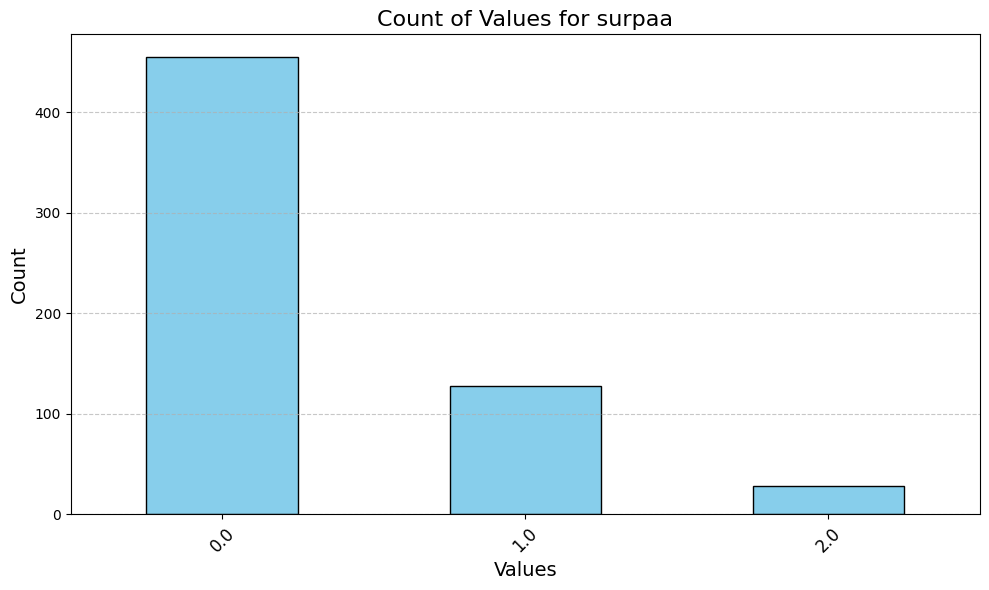

In [14]:
attribute = "surpaa"

value_counts = df_wina[attribute].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title(f'Count of Values for {attribute}', fontsize=16)
plt.xlabel('Values', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

I have decided to take out the attributes with too may NaNs (over 100). Too many NaNs will not work well with imputing strategies, and most of the time the attributes with too many are secondary nonetheless.

In [15]:
nan_counts = df_wina.isna().sum()

with pd.option_context('display.max_rows', None):
    print(nan_counts)

post1                2
post2              536
front               47
depth               47
time                47
aeroa               92
surpa               15
cea                117
leada              135
trnga              137
morala              45
logsa               58
momnta              39
intela              82
techa               41
inita               59
wina                 0
quala              112
resa               140
mobila              52
aira                65
fprepa              86
wxa                 99
terra              321
leadaa             140
plana               90
surpaa              49
mana                64
logsaa              51
fortsa             369
deepa              199
duration1            2
wofa                14
wofd                44
terra1              16
terra2              20
terra3             650
wx1                  1
wx2                  0
wx3                  1
wx4                  0
wx5                  0
attacker_str         1
attacker_in

In [ ]:
att_with_too_many_nans = ["post2", "terra", "fortsa", "deepa", "terra3", "attacker_rerp", "cfly_x",
                          "attacker_pri2", "attacker_pri3", "attacker_sec1", "attacker_sec2", "attacker_sec3",
                          "defender_rerp", "cfly_y", "defender_pri2", "defender_pri3", "defender_sec1", 
                          "defender_sec2", "defender_sec3", "cea", "leada", "trnga", "quala", "resa", "leadaa",
                          "attacker_instst", "attacker_fly", "attacker_arty", "defender_instst", 
                          "defender_arty", "defender_fly"]

df_wina = df_wina[[col for col in df_wina.columns if col not in att_with_too_many_nans]]

In [17]:
df_wina.shape

(660, 48)

In [18]:
print(df_wina["post1"].unique())

['HD' 'PD' 'FD' 'DL' 'WD' nan]


After taking out the columns with many NaNs, I want to impute manually with a 0 the NaNs in attributes where 0 means it favours neither the attacker nor the defender. For instance, *wxa*, the degree of influence of weather, takes values from 0 to 2, 0 meaning it didn't affect the outcome of the battle. Others, like *aeroa*, the attacker's relative air superiority, has values from -1 to 1, 0 meaning no side has an advantage.

As these two, there are several attributes where 0 is the neutral value.

In [19]:
columns_to_impute_with_0 = ['aeroa', 'surpa', 'morala', 'logsa', 'momnta', 'intela', 'inita', 'mobila', 
                            'aira', 'fprepa', 'wxa', 'plana', 'surpaa', 'mana', 'logsaa']


df_wina[columns_to_impute_with_0] = df_wina[columns_to_impute_with_0].fillna(0)
columns_to_impute_with_O = ['terra1', 'terra2']
df_wina[columns_to_impute_with_O] = df_wina[columns_to_impute_with_O].fillna("O")

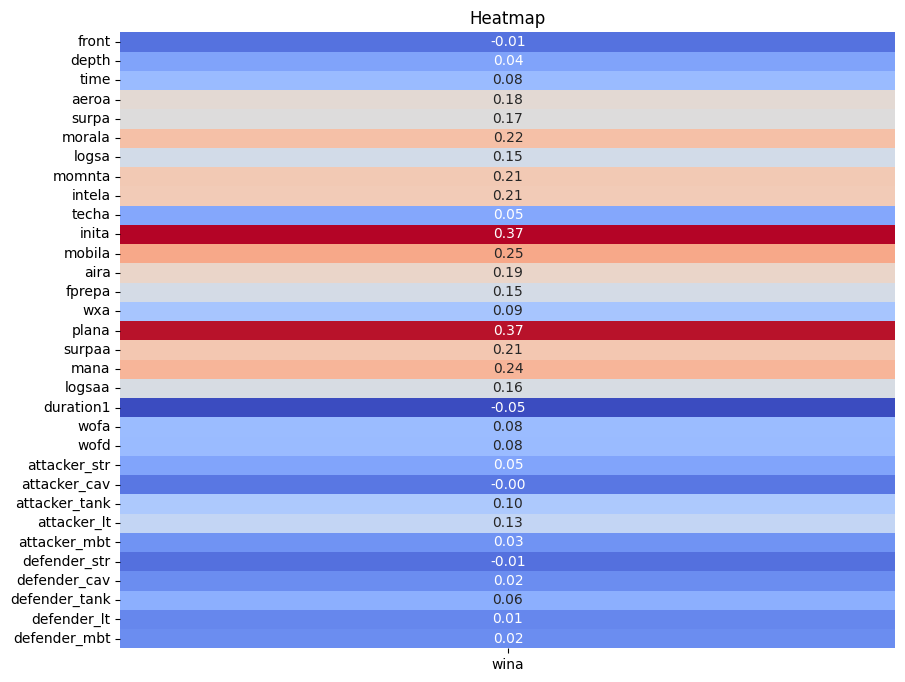

In [20]:
# Extraiem del dataset les variables no numèriques
num_feat = df_wina.select_dtypes(include=['int64', 'float64'])
corr_with_wina = num_feat.corr()['wina'].drop('wina')

# I visualitzem el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_with_wina.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
plt.title('Heatmap')
plt.show()

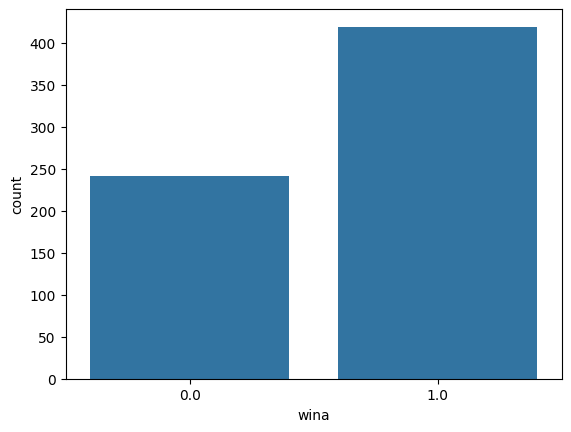

In [21]:
sns.countplot(x="wina", data=df_wina)
plt.show()

As we can see, it's an unbalanced dataset, where most battles are won by the attacker. We will have to take this into account when applying the different methods for classification.

We will take a look into the attribute *inita*, meaning the attacker's relative initiative advantage over the defender, with values ranging from 0 to 2. I've chosen this attribute since it's the attribute with the highest correlation to *wina*. Let's see what we get:

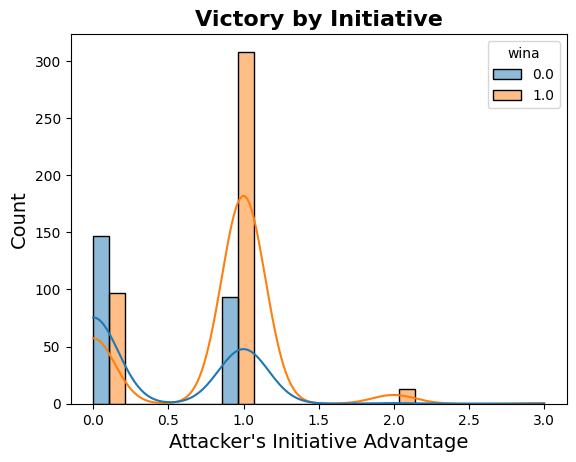

In [22]:
sns.histplot(data=df_wina, x="inita", hue="wina", multiple="dodge", edgecolor="black", kde=True)
# kde=True (Kernel Density Estimate) returns a curve, an estimator of the data's distribution


plt.title("Victory by Initiative", fontsize=16, fontweight='bold')
plt.xlabel("Attacker's Initiative Advantage", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

We can see that most battles that have a value of 1 or 2 are won by the attacker, supporting the view that initiative is crucial in battles. On the other side, in battles where neither side has the initiative (*inita=0*), the defender is more likely to win them, since they have other weapons (like preparations), at their disposal.

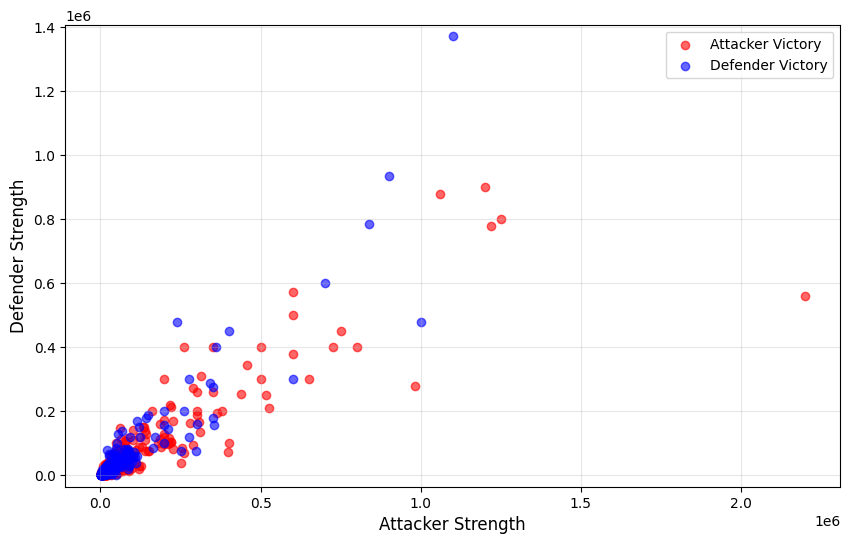

In [ ]:
plt.figure(figsize=(10, 6))

plt.scatter(
    df_wina[df_wina['wina'] == 1]['attacker_str'],
    df_wina[df_wina['wina'] == 1]['defender_str'],
    color='red', alpha=0.6, label='Attacker Victory'
)
plt.scatter(
    df_wina[df_wina['wina'] == 0]['attacker_str'],
    df_wina[df_wina['wina'] == 0]['defender_str'],
    color='blue', alpha=0.6, label='Defender Victory'
)

plt.xlabel('Attacker Strength', fontsize=12)
plt.ylabel('Defender Strength', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.axis('equal')
plt.show()


Large armies tend to draw large armies.

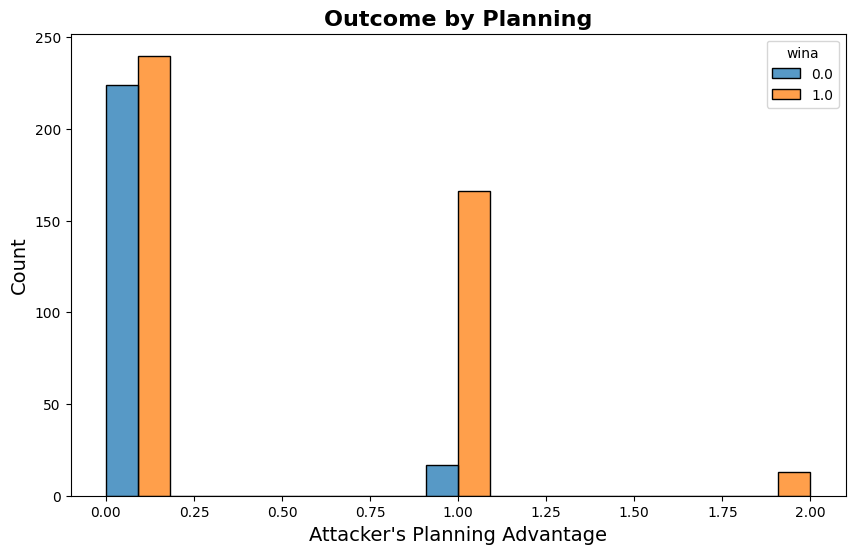

In [28]:
plt.figure(figsize=(10, 6))  # Adjust the figure size
sns.histplot(data=df_wina, x="plana", hue="wina", multiple="dodge", edgecolor="black")


plt.title("Outcome by Planning", fontsize=16, fontweight='bold')
plt.xlabel("Attacker's Planning Advantage", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

# Preprocessing

In this section we will process the different attributes that form our dataset. Let's first separate the X from y matrices, and perform a split from the train and test parts:

In [ ]:
X = df_wina[[col for col in df_wina.columns if col not in ["wina"]]]
y = df_wina["wina"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X

,post1,front,depth,time,aeroa,surpa,morala,logsa,momnta,intela,...,defender_cav,defender_tank,defender_lt,defender_mbt,defender_pri1,att_comm1,att_comm2,def_comm1,def_comm2,def_comm3
0,HD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1400.0,0.0,0.0,0.0,DO,ALBERT OF AUSTRIA,Missing,MAURICE OF NASSAU,Missing,Missing
1,HD,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,11000.0,0.0,0.0,0.0,DO,BUCQUOI,Missing,CHRISTIAN OF ANHALT-BERNBERG,Missing,Missing
2,HD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4000.0,0.0,0.0,0.0,DD,TILLY,CORDOVA,BADEN-DURLACH,Missing,Missing
3,PD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10000.0,0.0,0.0,0.0,DO,MANSFIELD,Missing,WALLENSTEIN,Missing,Missing
4,HD,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,10000.0,0.0,0.0,0.0,DO,TILLY,Missing,CHRISTIAN IV,Missing,Missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,PD,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,40.0,NaN,NaN,NaN,Missing,Missing,Missing,Missing,Missing
656,NaN,NaN,NaN,NaN,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,2160.0,NaN,NaN,NaN,Missing,Missing,Missing,Missing,Missing
657,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,238.0,NaN,NaN,NaN,Missing,Missing,Missing,Missing,Missing
658,HD,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,218.0,NaN,NaN,NaN,Missing,Missing,Missing,Missing,Missing


First of all, for the numerical attributes we will use **StandardScaler**, which is a form of standarization that works well with one of the models we'll use like SVM, and **SimpleImputer**, using the median, in order to avoid massive influence of outliers. I have also decided against using **KNNImputer**, since I feel there is a small amount of battles (even less when considering some attributes have dozens of NaNs). As a side note, we have also done a small imputing part above, when assigning 0's to some variables with NaNs.


Now, onto categorical variables. We must consider that there are some variables with high cardinality, others with low.

We will treat the categorical variables with low cardinality (4 or lower different values) with **SimpleImputer**, imputing the variables with the most frequent value (for categorical variables we have only one with 2 NaNs and another with 1, so it's not a problem), and **OneHotEncoder** to turn them into numerical (binary) variables.

Finally, we will apply **TargetEncoder** to the variables with high cardinality, encoding the variables with its winning percentage.

Let's start defining the different types of variables:

In [ ]:
num_feat = ["attacker_tank", "attacker_lt", "duration1", "wofa", "wofd", "attacker_str",
                    "attacker_cav", "attacker_mbt", "defender_str", "defender_cav", "defender_tank",
                    "defender_lt", "defender_mbt"]

low_card_feat = ["front", "depth", "time", "aeroa", "surpa", "morala", "logsa", "momnta", "intela", "techa",
                 "inita", "mobila", "aira", "fprepa", "wxa", "plana", "surpaa", "mana", "logsaa", "terra1", 
                 "wx1", "wx2", "wx3", "wx4", "wx5"]

high_card_feat = ["post1", "terra2", "attacker_pri1", "defender_pri1", "att_comm1", "att_comm2", "def_comm1",
             "def_comm2", "def_comm3"]
target_feat = "wina"

Defining the Encoding methods:

In [ ]:
num_transf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median')),                     
])

low_card_transf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

high_card_transf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('target_enc', TargetEncoder())
])

In [ ]:
num_cols = [col for col in num_feat if col in df_wina.columns]
low_card_cols = [col for col in low_card_feat if col in df_wina.columns]
high_card_cols = [col for col in high_card_feat if col in df_wina.columns]

Let's combine all the transformers into a single preprocessor:

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transf, num_cols),
        ('low_card_cat', low_card_transf, low_card_cols),
        ('high_card_cat', high_card_transf, high_card_cols),
    ],
    remainder='drop'
)

full_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [ ]:
full_pipeline.fit(X_train, y_train)

X_train_processed = full_pipeline.transform(X_train)
X_test_processed = full_pipeline.transform(X_test)

In [ ]:
one_hot_cols = (full_pipeline.named_steps['preprocessor']
                             .named_transformers_['low_card_cat']
                             .named_steps['onehot']
                             .get_feature_names_out(input_features=low_card_cols))

target_enc_cols = high_card_cols

processed_columns = num_cols + list(one_hot_cols) + target_enc_cols

X_train_processed_df = pd.DataFrame(X_train_processed, columns=processed_columns)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=processed_columns)
X_train_processed_df

,attacker_tank,attacker_lt,duration1,wofa,wofd,attacker_str,attacker_cav,attacker_mbt,defender_str,defender_cav,...,wx5_T,post1,terra2,attacker_pri1,defender_pri1,att_comm1,att_comm2,def_comm1,def_comm2,def_comm3
0,-0.361411,-0.373720,-0.983451,-0.304535,-0.296064,-0.379343,0.158458,-0.457122,-0.277875,0.781310,...,1.0,0.566831,0.639986,0.716515,0.726646,1.000000,0.635836,1.000000,0.635476,0.63447
1,1.906818,-0.373720,0.447970,14.268042,14.016296,5.170500,-0.429165,-0.457122,6.820859,-0.419147,...,1.0,0.566831,0.639986,0.606259,0.726646,1.000000,0.635836,1.000000,0.635476,0.63447
2,-0.198180,-0.373720,0.447970,0.111353,0.100561,1.022266,-0.429165,-0.457122,0.532936,-0.419147,...,1.0,0.657382,0.639986,0.606259,0.513493,0.730575,0.635836,0.000000,0.635476,0.63447
3,0.747198,1.954859,0.447970,-0.100722,-0.107904,-0.206987,-0.429165,1.655321,-0.367354,-0.419147,...,1.0,0.657382,0.639986,0.606259,0.513493,1.000000,0.635836,1.000000,0.635476,0.63447
4,-0.208382,-0.373720,0.447970,-0.219154,-0.224319,-0.354817,-0.429165,-0.073816,-0.297624,-0.419147,...,1.0,0.657382,0.639986,0.606259,0.726646,0.000000,0.635836,0.000000,0.635476,0.63447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,-0.361411,-0.373720,-0.983451,-0.281124,-0.221612,-0.310584,-0.429165,-0.457122,-0.418526,-0.419147,...,1.0,0.691902,0.548313,0.606259,0.726646,0.000000,0.635836,0.547094,0.635476,0.63447
524,-0.136969,-0.373720,0.447970,-0.274238,-0.278466,-0.423041,-0.429165,0.105060,-0.390561,-0.419147,...,0.0,0.566831,0.548313,0.606259,0.513493,0.000000,0.635836,0.000000,0.635476,0.63447
525,-0.272995,-0.373720,0.447970,-0.205383,-0.210783,-0.379343,-0.429165,-0.235656,-0.424317,-0.419147,...,1.0,0.691902,0.693316,0.606259,0.726646,1.000000,0.635836,1.000000,0.635476,0.63447
526,-0.361411,-0.373720,0.447970,-0.246696,-0.245978,-0.173068,-0.429165,-0.457122,-0.145498,-0.419147,...,1.0,0.566831,0.639986,0.816808,0.726646,1.000000,0.635836,0.547094,0.635476,0.63447


Let's apply a PCA and see how it goes:

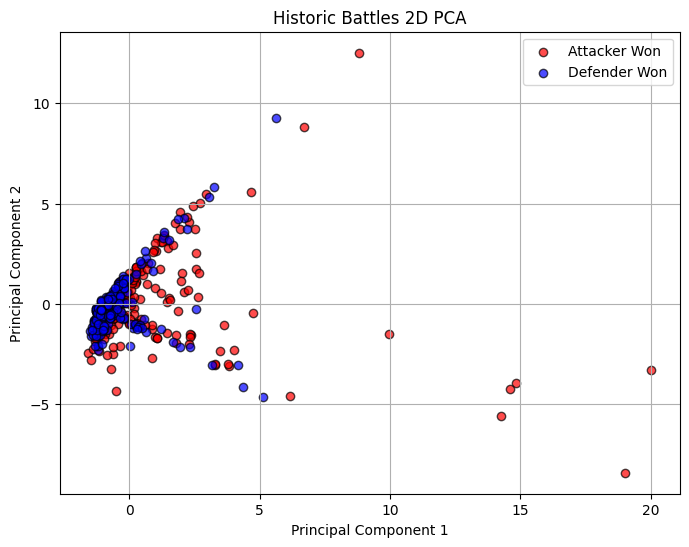

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_processed)

attacker_won = y_train == 1  # Attacker won
defender_won = y_train == 0  # Defender won

plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[attacker_won, 0], X_pca[attacker_won, 1],
    c='red', label='Attacker Won', alpha=0.7, edgecolors='k'
)
plt.scatter(
    X_pca[defender_won, 0], X_pca[defender_won, 1],
    c='blue', label='Defender Won', alpha=0.7, edgecolors='k'
)

plt.title('Historic Battles 2D PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()


As we can see, the PCA doesn't seem to offer any clear distinction between the two different values of *wina*. This was to be expected, since the dataset is too complex for just 2 variables.

Anyways, we have our dataset already encoded and standardized, ready for the models.

# Metric Selection

Before jumping to the models though, we must decide which metric will we use to label their performance. We will start by fitting a Logistic Regression model to the dataframe, in order to look at the values of the different metrics.

In [ ]:
model = LogisticRegression()
model.fit(X_train_processed, y_train)

y_pred = model.predict(X_train_processed)

print("Classification Report:")
print(classification_report(y_train, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_train, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.90      0.93       193
         1.0       0.95      0.98      0.96       335

    accuracy                           0.95       528
   macro avg       0.96      0.94      0.95       528
weighted avg       0.95      0.95      0.95       528

Accuracy Score:
0.9526515151515151


Since it is equally important to determine the False Positive (a predicted attacker's win when the defender actually won) as the False Negatives (the contrary), the primary metric for the model analysis will be the **F1-Score**. Because of this also, I have decided against using the PR-Curve, since it doesn't take into account the True Negatives. However, here's the ROC Curve:

ROC-AUC Score: 0.9940143840383575


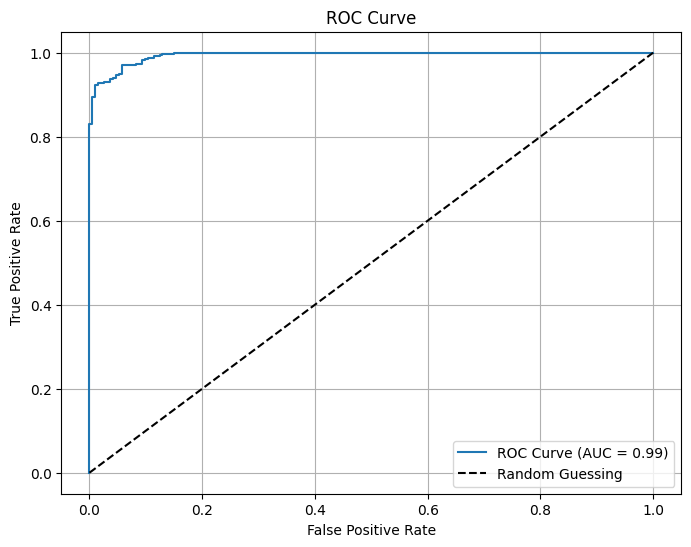

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_train, model.predict_proba(X_train_processed)[:, 1])

roc_auc = roc_auc_score(y_train, model.predict_proba(X_train_processed)[:, 1])
print(f"ROC-AUC Score: {roc_auc}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

The ROC curve shows us the TPR (recall) against the FPR for different thresholds. The curve stays well above the diagonal, which is a random classifier, meaning it works decent. A AUC score of 0.87 is, on the surface, also good.

However, in imbalanced datasets, the ROC Curve favours the majority class. For this reason, we can't say the AUC score of 0.87 is good, the only thing we can do is compare this value to other models.

# Prediction Models

When deciding the models I will use, things like class imbalance, the dataset size, computational and time costs of the model must be taken into consideration. I've finally decided for the following:

- **Logistic Regression**: an easy model to both implement and interpret, Logistic Regression works well for binary datasets, without much computational or time load. However, due to its simplicity, it's a model that will likely not yield the best results, couple that with the fact that the extensive amount of features in the dataset might cause overfitting. However, I believe it's good to have it to serve as a baseline to the other models
- **Random Forest**: a robust model that works well with imbalanced datasets, it captures complex relations, avoids overfitting and deals well with high dimensionality
- **SVM**: a model that works well with small and medium sized datasets like Historic Battles, that excels when dealing with high-dimensional data and can work well with imbalanced datasets
- **XGBoost**: an advanced implementation of Gradient Boosting, it often provides high accuracy, excelling with imbalanced datasets. Its main downside is the computational cost and execution time, which is considerable
- **LightGBM**: a lighter version of Gradient Boosting, it is significantly faster and less costly than XGBoost, all while retaining good performance, capturing non-linear relations

In [ ]:
# Definim els models que utilitzarem
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42)
}

# Definim els paràmetres i el rang d'aquest ens els quals farem la cerca
param_spaces = {
    'Logistic Regression': {
        'C': (0.0001, 50.0, 'log-uniform'),
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'],
        'max_iter': (50, 1000),
        'fit_intercept': [True],
        'class_weight': ['balanced']
    },
    'Random Forest': {
        'n_estimators': (10, 300),
        'max_depth': (3, 20),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (2, 10),
        'class_weight': ['balanced'],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False],
        'criterion': ['gini', 'entropy']
    },
    'SVM': {
        'C': (0.1, 100.0, 'log-uniform'),
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf', 'poly'],
        'degree': (2, 5),
        'coef0': (-1, 1),
        'class_weight': ['balanced'],
        'max_iter': (500, 5000)
    },
    'XGBoost': {
        'n_estimators': (50, 1500),
        'learning_rate': (0.001, 0.5, 'log-uniform'),
        'max_depth': (5, 15),
        'min_child_weight': (1, 5),
        'subsample': (0.5, 0.9),
        'colsample_bytree': (0.5, 0.9),
        'gamma': (0, 5),
        'scale_pos_weight': (1, 10),
        'max_delta_step': (0, 10),
        'objective': ['binary:logistic'],
        'eval_metric':['logloss','error','auc']
    },
    'LightGBM': {
        'n_estimators': (50, 1500),
        'learning_rate': (0.001, 0.5, 'log-uniform'),
        'num_leaves': (20, 40),
        'max_depth': (5, 15),
        'min_child_samples': (10, 30),
        'subsample': (0.5, 0.9),
        'colsample_bytree': (0.5, 0.9),
        'min_split_gain': (0.0, 1.0),
        'reg_alpha': (0.0, 1.0),
        'reg_lambda': (0.0, 1.0),
        'objective': ['binary'],
        'boosting_type': ['gbdt', 'dart', 'goss']
    }
}

In [ ]:
# Per a utilitzar deprés amb la funció cross_val_score, no amb BayesSearchCV
f1_scorer = make_scorer(f1_score, average='weighted')
skf= StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Diccionaris per guardar els millors models i paràmetres
millors_models = {}
millors_params = {}


# Define a dictionary to store progress bars for each model
for nom, model in tqdm(models.items(), desc="Optimizing Models", unit="model"):
    param_space = param_spaces[nom]

    opt = BayesSearchCV(
        model,
        param_space,
        n_iter=50,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring=f1_scorer,
        n_jobs=-1,
        random_state=42
    )

    # Fit the model and update the progress bar with the callback
    opt.fit(X_train_processed, y_train)

    # Save the best model and parameters
    millors_models[nom] = opt.best_estimator_
    millors_params[nom] = opt.best_params_

Optimizing Models:  20%|██        | 1/5 [02:16<09:06, 136.62s/model]

Model Logistic Regression DONE


Optimizing Models:  40%|████      | 2/5 [05:45<08:56, 178.96s/model]

Model Random Forest DONE


Optimizing Models:  60%|██████    | 3/5 [08:32<05:46, 173.50s/model]

Model SVM DONE


Optimizing Models:  80%|████████  | 4/5 [12:43<03:24, 204.03s/model]

Model XGBoost DONE
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 335, number of negative: 193
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 995
[LightGBM] [Info] Number of data points in the train set: 528, number of used features: 71
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.634470 -> initscore=0.551440
[LightGBM] [Info] Start training from score 0.551440
[LightGBM] [Warning] No further splits wi

Optimizing Models: 100%|██████████| 5/5 [19:20<00:00, 232.15s/model]

Model LightGBM DONE


In [ ]:
# Avaluem els models amb els millors hiperparàmetres i recollim els resultats
resultats_bayes = []
for nom, model in tqdm(millors_models.items(), desc="Predicting With Models", unit="model"):
    y_train_pred = model.predict(X_train_processed)
    y_test_pred = model.predict(X_test_processed)

    # Puntuacions f1 (per train i test)
    f1_score_entrenament = f1_score(y_train, y_train_pred, average='weighted')
    f1_score_prova = f1_score(y_test, y_test_pred, average='weighted')
    
    # Trobem les puntuacions de realitzar la validació creuada amb 10 folds, per tenir un altre resultat més robust
    cv_scores = cross_val_score(model, X_train_processed, y_train, cv=skf, scoring=f1_scorer).mean()

    # Millors paràmetres
    millors_parametres = millors_params[nom]
    parametres_aplanats = [f"{param}: {valor}" for param, valor in millors_parametres.items()]
    parametres_str = ", ".join(parametres_aplanats)

    resultats_bayes.append([nom, f1_score_entrenament, f1_score_prova, cv_scores, parametres_str])

Predicting With Models:  80%|████████  | 4/5 [00:05<00:01,  1.60s/model]

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 251, number of negative: 145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing

Predicting With Models: 100%|██████████| 5/5 [00:09<00:00,  1.94s/model]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
# Convertim els resultats a DataFrame per a una millor visualització
resultats_bayes = pd.DataFrame(resultats_bayes, columns=['Model', 'F1-score d\'Entrenament', 'F1-score de Prova','Cross Validation F1-score' ,'Millors Paràmetres'])
pd.set_option('display.max_colwidth', None)
resultats_bayes


,Model,F1-score d'Entrenament,F1-score de Prova,Cross Validation F1-score,Millors Paràmetres
0,Logistic Regression,0.943303,0.729401,0.926189,"C: 0.32863722472208245, class_weight: balanced, fit_intercept: True, max_iter: 881, penalty: l2, solver: liblinear"
1,Random Forest,0.964213,0.765659,0.922248,"bootstrap: False, class_weight: balanced, criterion: gini, max_depth: 12, max_features: sqrt, min_samples_leaf: 7, min_samples_split: 6, n_estimators: 300"
2,SVM,0.947136,0.720303,0.924458,"C: 0.21137407169015643, class_weight: balanced, coef0: 0, degree: 5, gamma: scale, kernel: linear, max_iter: 3264"
3,XGBoost,0.980948,0.696775,0.923351,"colsample_bytree: 0.9, eval_metric: error, gamma: 2, learning_rate: 0.1565634174035432, max_delta_step: 10, max_depth: 11, min_child_weight: 2, n_estimators: 1109, objective: binary:logistic, scale_pos_weight: 8, subsample: 0.7131450695919568"
4,LightGBM,0.944162,0.689297,0.915413,"boosting_type: goss, colsample_bytree: 0.708106767098377, learning_rate: 0.0010678294861425667, max_depth: 9, min_child_samples: 22, min_split_gain: 0.8558685931841127, n_estimators: 1489, num_leaves: 29, objective: binary, reg_alpha: 0.49252707957340136, reg_lambda: 0.09473219318552092, subsample: 0.5"


In [ ]:
voting_clf = VotingClassifier(
    estimators=[
        ('logreg', millors_models['Logistic Regression']),
        ('rf', millors_models['Random Forest']),
        ('svm', millors_models['SVM']),
        ('xgb', millors_models['XGBoost']),
        ('lgbm', millors_models['LightGBM']),
    ],
    voting='soft',  
    weights=[3,15,3,0,1]  
)

voting_clf.fit(X_train_processed, y_train)

y_pred = voting_clf.predict(X_test_processed)
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-Score of Voting Classifier:", f1)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 335, number of negative: 193
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 995
[LightGBM] [Info] Number of data points in the train set: 528, number of used features: 71
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.634470 -> initscore=0.551440
[LightGBM] [Info] Start training from score 0.551440
[LightGBM] [Warning] No further splits with positive gain, b

In [ ]:
base_models = [
    ('svm', millors_models['SVM']),
    ('logreg', millors_models['Logistic Regression']),
    ('rf', millors_models['Random Forest']),
    ('xgb', millors_models['XGBoost']),
    ('lgbm', millors_models['LightGBM'])
]

meta_model = LogisticRegression(random_state=42)

stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5  
)

stacking_clf.fit(X_train_processed, y_train)

y_pred = stacking_clf.predict(X_test_processed)
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-Score of Stacking Classifier:", f1)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 335, number of negative: 193
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 995
[LightGBM] [Info] Number of data points in the train set: 528, number of used features: 71
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.634470 -> initscore=0.551440
[LightGBM] [Info] Start training from score 0.551440
[LightGBM] [Warning] No further splits with positive gain, b

Let's look at the feature importances of the Random Forest in order to see if we can improve the model.

In [ ]:
feature_importances = millors_models["Random Forest"].feature_importances_

features = X_train_processed_df.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(30))

          Feature  Importance
93      def_comm1    0.296880
91      att_comm1    0.238393
55      plana_0.0    0.048382
39      inita_0.0    0.046125
56      plana_1.0    0.042105
40      inita_1.0    0.041424
43     mobila_0.0    0.024086
44     mobila_1.0    0.020646
90  defender_pri1    0.017529
25     morala_0.0    0.013431
33     intela_0.0    0.011699
8    defender_str    0.010621
4            wofd    0.010323
3            wofa    0.009573
5    attacker_str    0.009172
32     momnta_1.0    0.008898
0   attacker_tank    0.008724
31     momnta_0.0    0.008340
89  attacker_pri1    0.007769
61       mana_0.0    0.006216
26     morala_1.0    0.005936
46       aira_0.0    0.005916
87          post1    0.005365
34     intela_1.0    0.005286
62       mana_1.0    0.005187
20      aeroa_1.0    0.004944
19      aeroa_0.0    0.004753
58     surpaa_0.0    0.004654
2       duration1    0.004524
1     attacker_lt    0.004365


Let's discard some variables that Random Forest doesn't give many importance to, and train the dataset again.

In [ ]:
original_features = X_train_processed_df.columns.tolist()

low_importance_features = importance_df[importance_df['Importance'] < 0.001]

low_importance_list = low_importance_features['Feature'].tolist()


indices_to_discard = [original_features.index(attr) for attr in low_importance_list]

X_train_processed = np.delete(X_train_processed, indices_to_discard, axis=1)
X_test_processed = np.delete(X_test_processed, indices_to_discard, axis=1)

Features with importance lower than 0.001:
['terra2', 'logsa_1.0', 'terra1_G', 'fprepa_2.0', 'logsaa_1.0', 'terra1_F', 'surpa_1.0', 'morala_2.0', 'fprepa_1.0', 'surpa_2.0', 'wx2_H', 'wx4_W', 'wx3_C', 'logsa_2.0', 'inita_2.0', 'front_1.0', 'front_0.0', 'terra1_O', 'depth_1.0', 'time_1.0', 'wxa_0.0', 'wxa_1.0', 'def_comm2', 'techa_0.0', 'depth_0.0', 'time_0.0', 'surpa_3.0', 'intela_2.0', 'techa_1.0', 'att_comm2', 'aira_2.0', 'wx5_E', 'logsaa_2.0', 'mana_2.0', 'plana_2.0', 'wxa_2.0', 'mobila_2.0', 'inita_3.0', 'techa_2.0', 'def_comm3']


In [ ]:
# Per a utilitzar deprés amb la funció cross_val_score, no amb BayesSearchCV
f1_scorer = make_scorer(f1_score, average='weighted')
skf= StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Diccionaris per guardar els millors models i paràmetres
rf = {}
millors_params_rf = {}


opt = BayesSearchCV(
    models["Random Forest"],
    param_spaces["Random Forest"],
    n_iter=50,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=f1_scorer,
    n_jobs=-1,
    random_state=42
)

    # Fit the model and update the progress bar with the callback
opt.fit(X_train_processed, y_train)

    # Save the best model and parameters
rf["Random Forest"] = opt.best_estimator_
millors_params_rf["Random Forest"] = opt.best_params_

In [ ]:
# Avaluem els models amb els millors hiperparàmetres i recollim els resultats
resultats_bayes = []
for nom, model in tqdm(rf.items(), desc="Predicting With Models", unit="model"):
    y_train_pred = model.predict(X_train_processed)
    y_test_pred = model.predict(X_test_processed)

    # Puntuacions f1 (per train i test)
    f1_score_entrenament = f1_score(y_train, y_train_pred, average='weighted')
    f1_score_prova = f1_score(y_test, y_test_pred, average='weighted')
    
    # Trobem les puntuacions de realitzar la validació creuada amb 10 folds, per tenir un altre resultat més robust
    cv_scores = cross_val_score(model, X_train_processed, y_train, cv=skf, scoring=f1_scorer).mean()

    # Millors paràmetres
    millors_parametres = millors_params_rf[nom]
    parametres_aplanats = [f"{param}: {valor}" for param, valor in millors_parametres.items()]
    parametres_str = ", ".join(parametres_aplanats)

    resultats_bayes.append([nom, f1_score_entrenament, f1_score_prova, cv_scores, parametres_str])

Predicting With Models: 100%|██████████| 1/1 [00:02<00:00,  2.66s/model]


In [ ]:
# Convertim els resultats a DataFrame per a una millor visualització
resultats_bayes = pd.DataFrame(resultats_bayes, columns=['Model', 'F1-score d\'Entrenament', 'F1-score de Prova','Cross Validation F1-score' ,'Millors Paràmetres'])
pd.set_option('display.max_colwidth', None)
resultats_bayes


,Model,F1-score d'Entrenament,F1-score de Prova,Cross Validation F1-score,Millors Paràmetres
0,Random Forest,0.962347,0.774501,0.918573,"bootstrap: False, class_weight: balanced, criterion: gini, max_depth: 9, max_features: sqrt, min_samples_leaf: 6, min_samples_split: 8, n_estimators: 282"


This improved Random Forest does not improve the results of the Voting Classifier.

# Final Analysis

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
ROC-AUC Score: 0.7631448412698412


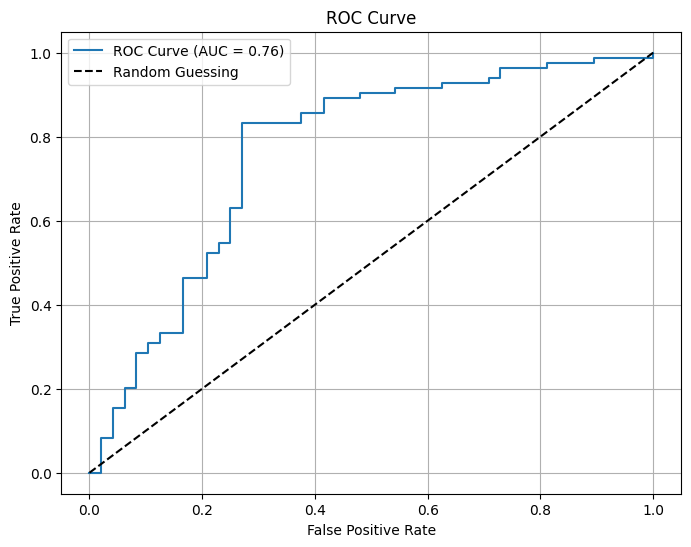

In [ ]:
y_probs = voting_clf.predict_proba(X_test_processed)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC-AUC Score: {roc_auc}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

In [ ]:
best_threshold = 0
best_f1 = 0

# Rang de thresholds pels quals volem maximitzar
thresholds = np.linspace(0, 1, 1000)

# Maximitzem el F1-score weighted
for threshold in thresholds:
    y_pred_with_threshold = (y_probs > threshold).astype(int)
    current_f1 = f1_score(y_test, y_pred_with_threshold, average='weighted')

    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = threshold

print("Millor threshold:", best_threshold)
print("Millor F1-score weighted:", best_f1)

Millor threshold: 0.5145145145145145
Millor F1-score weighted: 0.795896491927111


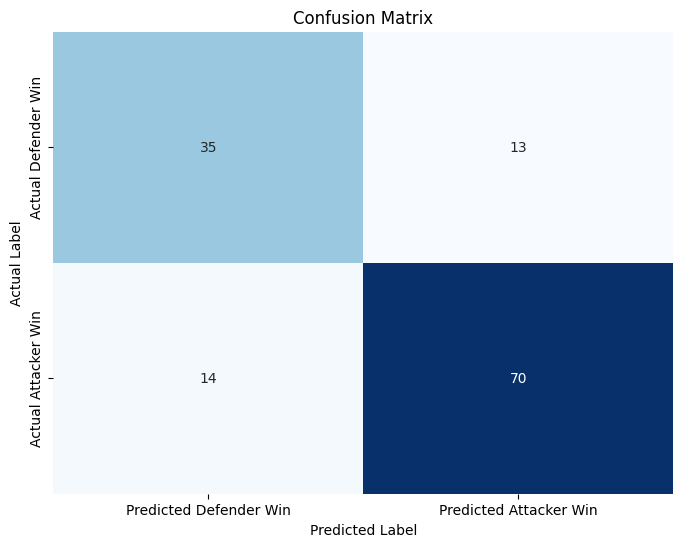

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Defender Win', 'Predicted Attacker Win'], 
                yticklabels=['Actual Defender Win', 'Actual Attacker Win']) 
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

# Assignem la classe a y segons si la seva probabilitat de pertànyer a la classe 1 és superior al millor threshold trobat
y_pred_with_threshold = (y_probs > best_threshold).astype(int)

plot_confusion_matrix(y_test, y_pred_with_threshold)

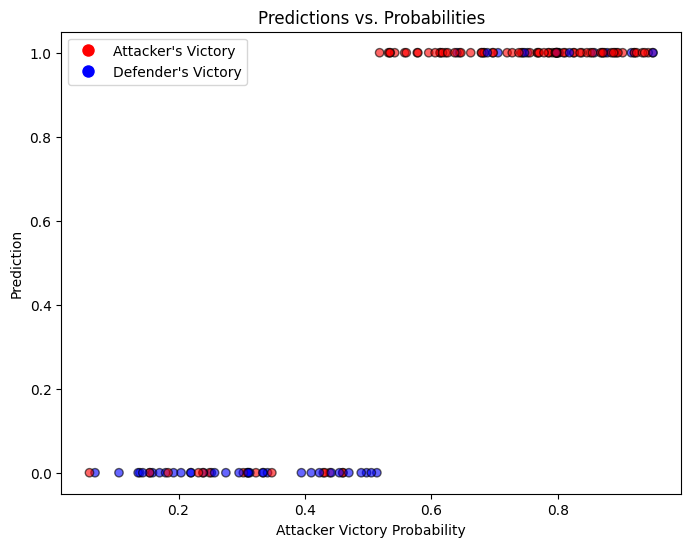

In [ ]:
colors = ['red' if pred == 1 else 'blue' for pred in y_test]

plt.figure(figsize=(8, 6))
plt.scatter(y_probs, y_pred_with_threshold, c=colors, alpha=0.6, edgecolor='k')

plt.xlabel('Attacker Victory Probability')
plt.ylabel('Prediction')
plt.title('Predictions vs. Probabilities')


legend_elements = [
    Line2D([0], [0], marker='o', color='w', label="Attacker's Victory", markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label="Defender's Victory", markerfacecolor='blue', markersize=10)
]
plt.legend(handles=legend_elements, loc='best')

plt.show()


Let's take a look at the ourliers.

In [ ]:
prob_1_actual_0 = np.where((y_probs > 0.8) & (y_test == 0))[0]

pd.DataFrame(X_test_processed[prob_1_actual_0], columns=processed_columns)

,attacker_tank,attacker_lt,duration1,wofa,wofd,attacker_str,attacker_cav,attacker_mbt,defender_str,defender_cav,...,wx5_T,post1,terra2,attacker_pri1,defender_pri1,att_comm1,att_comm2,def_comm1,def_comm2,def_comm3
0,5.759747,-0.373720,0.447970,9.310446,9.143082,5.380477,-0.429165,-0.457122,10.891462,-0.419147,...,1.0,0.691902,0.639986,0.606259,0.513493,0.634470,0.635836,0.634470,0.635476,0.63447
1,0.050067,0.969691,0.447970,-0.297649,-0.301479,-0.333253,-0.429165,0.190240,-0.416176,-0.419147,...,1.0,0.657382,0.639986,0.606259,0.513493,0.705372,0.635836,0.662233,0.635476,0.63447
2,-0.361411,-0.373720,-0.983451,-0.095214,-0.143099,-0.236537,0.410297,-0.457122,-0.046215,1.981767,...,1.0,0.566831,0.693316,0.606259,0.726646,1.000000,0.635836,1.000000,0.635476,0.63447
3,-0.361411,-0.373720,0.447970,-0.296272,-0.300125,-0.198207,1.554484,-0.457122,-0.294174,0.721287,...,1.0,0.566831,0.639986,0.606259,0.513493,1.000000,0.635836,1.000000,0.635476,0.63447
4,0.264307,0.223351,-0.983451,-0.191612,-0.197246,-0.380400,-0.429165,0.939816,-0.435073,-0.419147,...,1.0,0.691902,0.701473,0.606259,0.726646,1.000000,0.635836,1.000000,0.635476,0.63447
5,0.077272,1.387641,0.447970,-0.294895,-0.298771,-0.326594,-0.429165,0.139132,-0.420536,-0.419147,...,1.0,0.657382,0.639986,0.606259,0.726646,0.705372,0.635836,0.662233,0.635476,0.63447


In [ ]:
original_attributes = ['att_comm1', 'def_comm1', 'inita', 'plana', 'mobila', 'morala', 'attacker_str', 'defender_str',
                       'attacker_tank', 'defender_tank']  

original_values = X_test.iloc[prob_1_actual_0][original_attributes]

print(original_values)

       att_comm1         def_comm1  inita  plana  mobila  morala  \
488  FM VON BOCK    MARSHAL STALIN    2.0    1.0     1.0     0.0   
542   MG BRADLEY        LG AMAMIYA    1.0    0.0     1.0     0.0   
108      JOURDAN  ARCHDUKE CHARLES    1.0    0.0     0.0     0.0   
215     SHERIDAN           PICKETT    1.0    1.0     0.0     1.0   
557     BG YOFFE         MG NASSER    1.0    0.0     0.0     1.0   
543   MG BRADLEY        LG AMAMIYA    1.0    0.0     1.0     0.0   

     attacker_str  defender_str  attacker_tank  defender_tank  
488     1100000.0     1372000.0         1800.0          950.0  
542       19714.0        5284.0          121.0            0.0  
108       38000.0       50000.0            0.0            0.0  
215       45247.0       20030.0            0.0            0.0  
557       10800.0        3000.0          184.0           60.0  
543       20973.0        4757.0          129.0            0.0  


In [ ]:
prob_0_actual_1 = np.where((y_probs < 0.5) & (y_test == 1))[0]

pd.DataFrame(X_test_processed[prob_0_actual_1], columns=processed_columns)

,attacker_tank,attacker_lt,duration1,wofa,wofd,attacker_str,attacker_cav,attacker_mbt,defender_str,defender_cav,...,wx5_T,post1,terra2,attacker_pri1,defender_pri1,att_comm1,att_comm2,def_comm1,def_comm2,def_comm3
0,-0.361411,-0.373720,-0.983451,-0.246696,-0.298771,-0.215381,0.326351,-0.457122,-0.228233,0.281120,...,1.0,0.566831,0.693316,0.606259,0.726646,0.634470,0.635836,0.634470,0.635476,0.63447
1,-0.361411,-0.373720,-0.983451,-0.252204,-0.275759,-0.014395,4.271824,-0.457122,-0.203413,1.581615,...,1.0,0.691902,0.639986,0.606259,0.726646,0.547094,0.635836,0.000000,0.635476,0.63447
2,-0.361411,-0.373720,0.447970,0.249064,0.235929,0.096676,-0.429165,-0.457122,0.706682,-0.419147,...,1.0,0.566831,0.639986,0.606259,0.513493,0.634470,0.635836,0.634470,0.635476,0.63447
3,-0.361411,-0.373720,-0.983451,-0.274238,-0.267637,-0.395210,-0.429165,-0.457122,-0.430936,-0.419147,...,1.0,0.691902,0.639986,0.606259,0.726646,0.000000,0.635836,0.000000,0.634470,0.63447
4,-0.096161,-0.373720,0.447970,-0.274238,-0.278466,-0.352897,-0.429165,0.207275,-0.412403,-0.419147,...,1.0,0.566831,0.693316,0.606259,0.726646,0.000000,0.635836,0.634470,0.635476,0.63447
5,-0.361411,-0.373720,-0.834345,-0.307289,-0.310954,-0.426415,-0.429165,-0.457122,-0.434659,-0.419147,...,1.0,0.566831,0.639986,0.606259,0.726646,1.000000,0.635836,0.000000,0.635476,0.63447
6,-0.000943,0.133791,0.447970,-0.263221,-0.267637,-0.348296,-0.429165,0.300973,-0.407596,-0.419147,...,1.0,0.691902,0.639986,0.606259,0.513493,0.406232,0.635836,0.404101,0.635476,0.63447
7,-0.361411,-0.373720,3.131884,-0.274238,-0.278466,-0.100094,-0.429165,-0.457122,-0.116548,-0.094223,...,1.0,0.657382,0.639986,0.606259,0.726646,0.634470,0.635836,0.000000,0.635476,0.63447
8,-0.361411,-0.373720,-0.983451,-0.241188,-0.278466,0.038496,0.326351,-0.457122,-0.079309,-0.419147,...,1.0,0.566831,0.639986,0.606259,0.513493,0.634470,0.635836,0.000000,0.635476,0.63447
9,-0.361411,-0.373720,0.447970,-0.108985,-0.116026,-0.120177,1.249759,-0.457122,0.036521,2.581995,...,1.0,0.566831,0.693316,0.606259,0.726646,0.634470,0.635836,0.634470,0.635476,0.63447


In [ ]:
original_attributes = ['att_comm1', 'def_comm1', 'inita', 'plana', 'mobila', 'morala', 'attacker_str', 'defender_str',
                       'attacker_tank', 'defender_tank', 'def_comm2'] 

original_values = X_test.iloc[prob_0_actual_1][original_attributes]

print(original_values)

            att_comm1        def_comm1  inita  plana  mobila  morala  \
221         STEINMETZ         FROSSARD    1.0    0.0     0.0     0.0   
72               DAUN     FREDERICK II    1.0    2.0     0.0     0.0   
273        GEN HAUSEN         GEN FOCH    0.0    0.0     0.0     0.0   
235           METHUEN           CRONJE    0.0    0.0     0.0     1.0   
624       GEN KRUEGER       COL NELSON    1.0    0.0     0.0     0.0   
90         CORNWALLIS            GATES    1.0    0.0     0.0     0.0   
413          MG RYDER         MG BAADE    0.0    0.0     0.0     0.0   
208            BUTLER       BEAUREGARD    1.0    0.0     0.0     0.0   
190         MCCLELLAN              LEE    1.0    0.0     0.0     0.0   
113            MOREAU             KRAY    0.0    0.0     0.0     0.0   
227    FRIEDRICK KARL           CHANZY    0.0    0.0     0.0     0.0   
2               TILLY    BADEN-DURLACH    0.0    0.0     0.0     0.0   
103  ARCHDUKE CHARLES           MOREAU    0.0    0.0     0.0    

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.

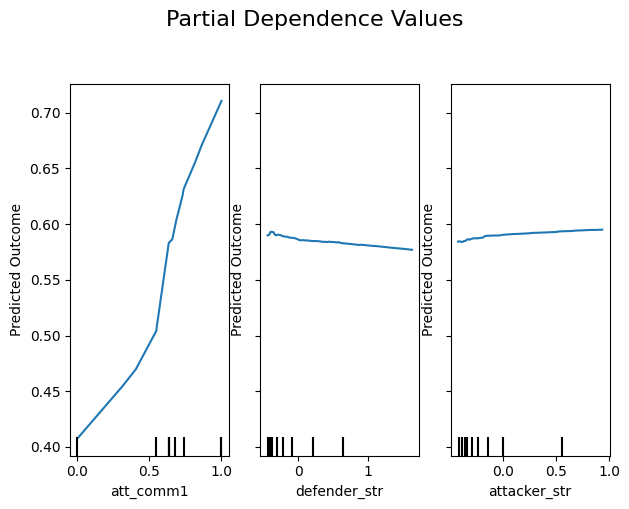

In [355]:
import warnings
warnings.filterwarnings('ignore')

display = PartialDependenceDisplay.from_estimator(
    estimator=voting_clf,
    X=X_test_processed_df,
    features=["att_comm1", "defender_str", "attacker_str"], 
    feature_names=X_test_processed_df.columns
)


for ax in display.axes_.ravel():
    ax.set_ylabel("Predicted Outcome") 

plt.suptitle("Partial Dependence Values", fontsize=16, y=1.05) 
plt.tight_layout() 
plt.show()
